# A/B testing d'une campagne promotionnelle pour un produit fast-foost

Une entreprise de chaînes de fast-food a testé 3 promotions, et souhaite connaître celle qui fonctionne le mieux.

A notre disposition, nous avons quelques données : sur les marchés ciblés, les différentes version de la promotion, le montant des ventes par magasin, l'âge du magasin, la semaine de diffusion (quatre semaines au total).

Nous pouvons fixer 3 objectifs :
1. Quel est la version qui a amené le plus de ventes ?
2. Quels résultats selon la taille du marché ?
3. Quels résultats sur les magains les plus jeunes vs les plus implantés ?

Pour ce faire, il convient de réaliser une analyse complète du jeu de données pour le comprendre, de réaliser les tests statistiques adéquats pour prouver l'effet, et de quantifier les gains permis par la meilleure promotion.

## 1. Import et qualité des données

In [4]:
#Import des librairies
import pandas as pd
import numpy as np

#Import du jeu de données et premier apperçu
df = pd.read_csv('WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [5]:
#Informations essentielles sur le jeu de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [6]:
#Nombre de lignes duppliquées
df.duplicated().sum()

0

In [7]:
#Description statistique des variables quantitatives
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


In [8]:
#Pour la variable catégorielle, nombre de valeurs par occurence.
df['MarketSize'].value_counts()
    

MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

Pas de problème de qualité de donnée repérée : pas de valeurs nulles, de valeurs manquantes, pas de lignes duppliquées. Nous pouvons donc passer à l'analyse exploratoire des données.

## 2. Analyse Exploratoire des Données (EDA)

### a. Analyse univariée

Commençons par nous familiariser avec la distribution de chacune des variables.

In [13]:
#Librairies pour la Datavisualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Pour améliorer la visualisation des graphiques construits avec Seaborn
sns.set_theme()

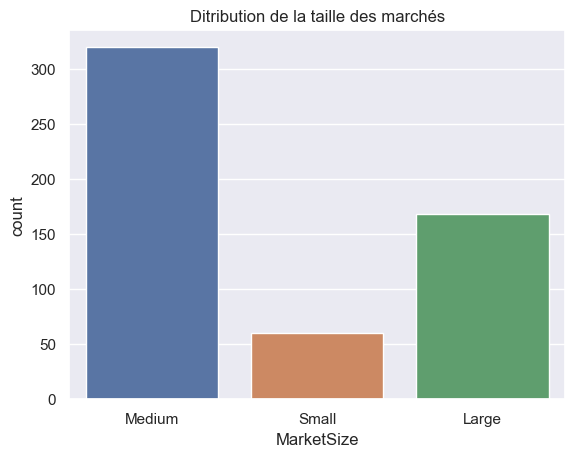

In [14]:
#Nombre de valeurs par occurence pour la variable catégorielle
sns.countplot(x = df['MarketSize'])
plt.title('Ditribution de la taille des marchés');

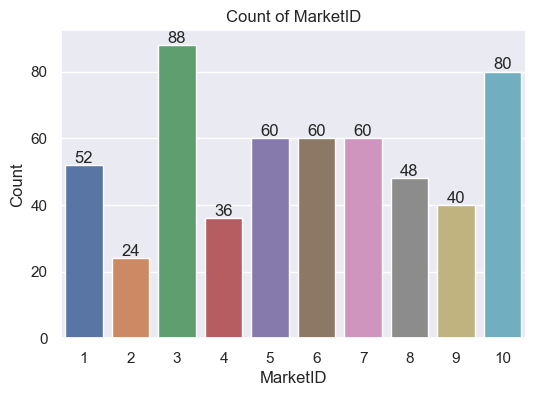

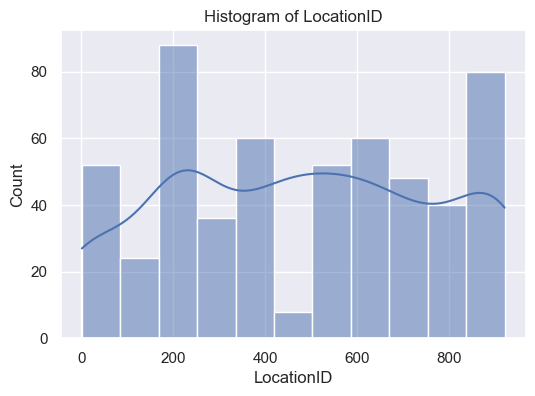

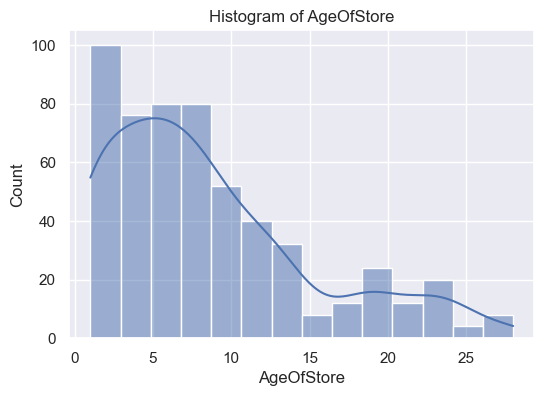

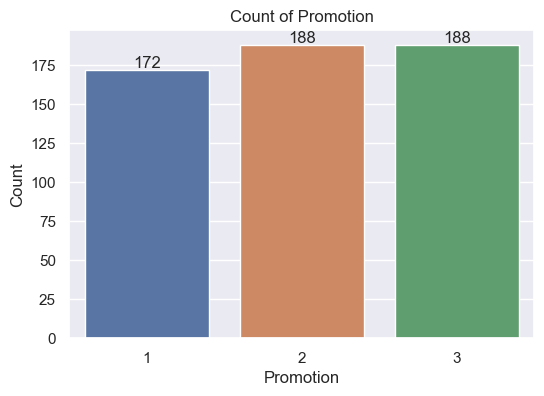

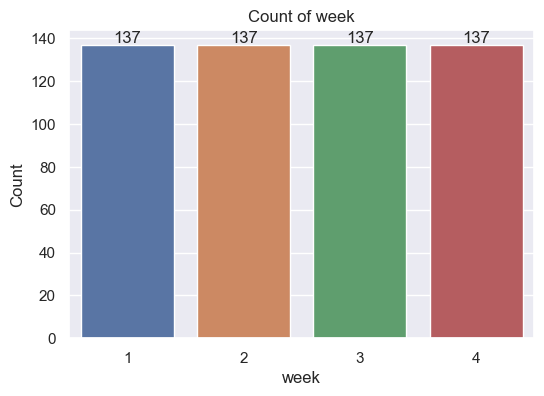

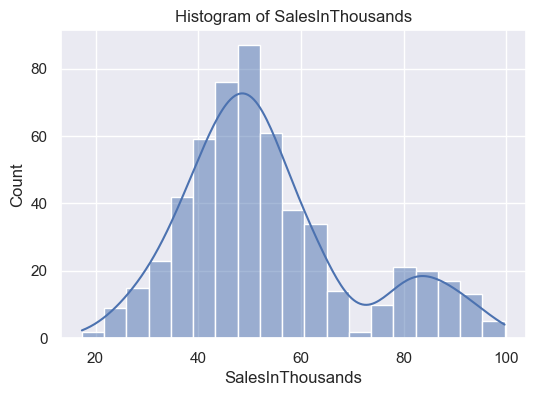

In [15]:
# Distribution des variables quantitatives

# Identifier les colonnes quantitatives
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Construire les graphiques pour chaque colonne quantitative
for column in numerical_columns:
    # Pour les variables continues
    if len(df[column].unique()) > 10:  # Assuming if unique values > 10, consider it continuous
        plt.figure(figsize=(6, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()
    else:  # Pour les variables discrètes ou continues
        plt.figure(figsize=(6, 4))
        ax = sns.countplot(x=column, data=df)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        
        # Annotation de chaque barre avec le décompte des valeurs
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 5), 
                        textcoords = 'offset points')
        plt.show()

Voici les conclusions que nous pouvons tirer de l'analyse univariée :
- Il y a peu de petits marchés, mais suffisamment de marchés moyens et de gros marchés pour conduire une analyse.
- Les variables 'week' et 'promotion' sont des variables discrètes. Peut-être à changer pour le test.
- Les magasins sont relativement jeunes. 25% ont 4 ans ou moins, et seuls 25% ont 12 ans ou plus. Ce qui permettra d'analyser l'impact selon la maturité des magasins, notamment les plus récents qui ont plus d'enjeux d'attirer et de retenir la clientèle.
- Une distribution des copies proche (variable promotion).
- Une distribution des semaines parfaitement égale.
- Une ditribution des ventes divisée en deux groupes. Le premier autour d'un pic de ventes à 50k, concentrant probablement les magasins des petits et moyens marchés, et l'un à partir de 70k jusqu'à 100k, probablement dans les marchés plus importants. 

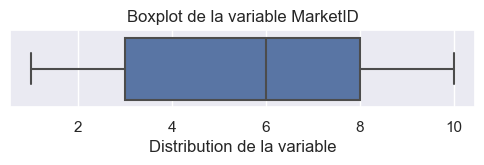

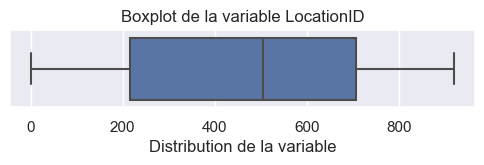

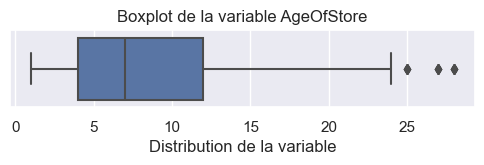

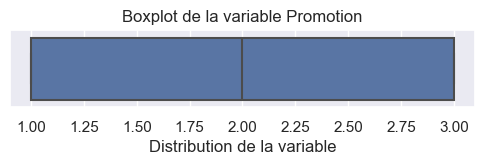

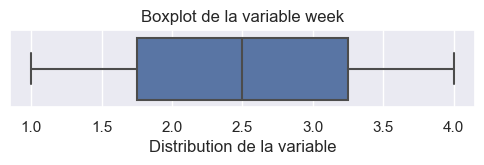

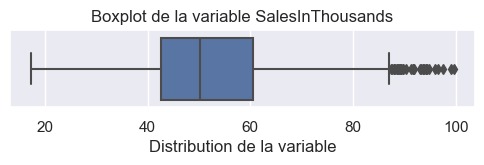

In [17]:
# Voyons également s'il y a des outliers :

for col in numerical_columns :
    plt.figure(figsize = (6, 1))
    sns.boxplot(x = df[col])
    plt.title(f'Boxplot de la variable {col}')
    plt.xlabel('Distribution de la variable')
    plt.show()

Il y a quelques valeurs extrêmes mais aucune valeur abberante. Pour l'âge du magasin, il est probable que certains magasins soient très anciens. Et pour les ventes, certains magasins génèrent plus de chiffres que d'autres, comme nous avons pu le constater quand nous avons visualisé la distribution.

### b. Analyse bi-variée

Analysons la relation des variables avec les différentes promotions mises en place, pour déceler de potentiels enseignements.

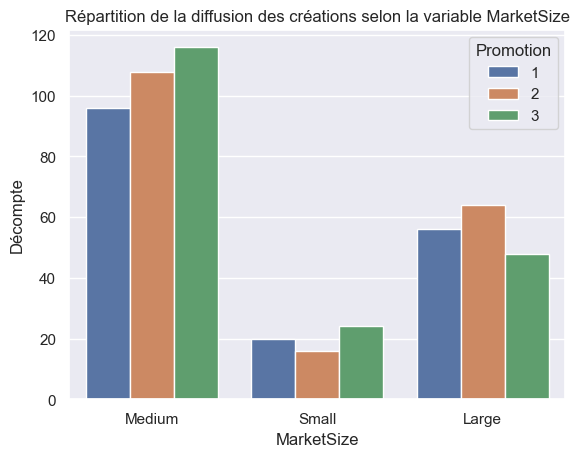

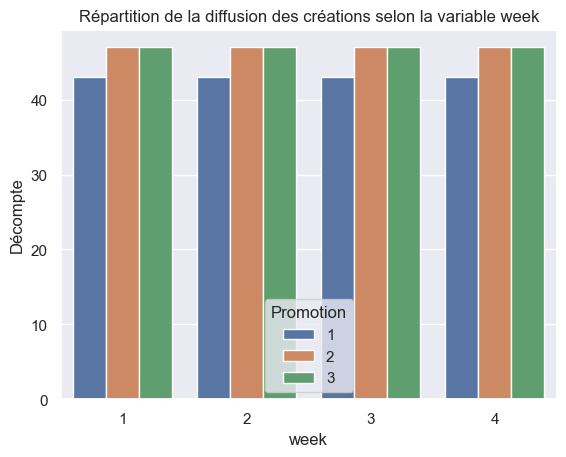

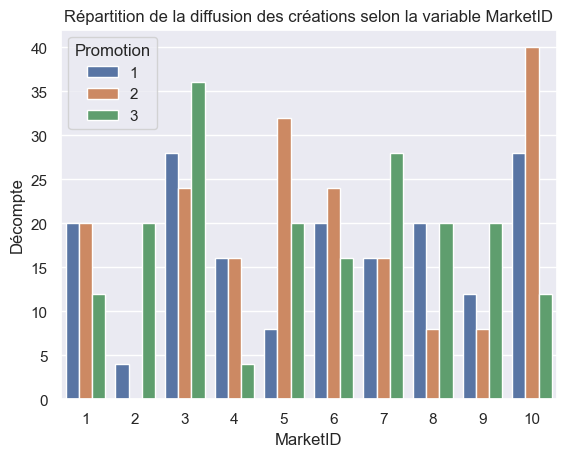

In [21]:
#Variables discrètes du jeu de données
discrete_col = ['MarketSize', 'week', 'MarketID']

#Construire les graphiques pour chaque variable, différencié selon les promotions.
for col in discrete_col:
    plt.figure()
    sns.countplot(x = df[col], hue = df["Promotion"])
    plt.title(f"Répartition de la diffusion des créations selon la variable {col}")
    plt.xlabel(col)
    plt.ylabel('Décompte')
    plt.show()

C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
C:\Users\cleme\anaco

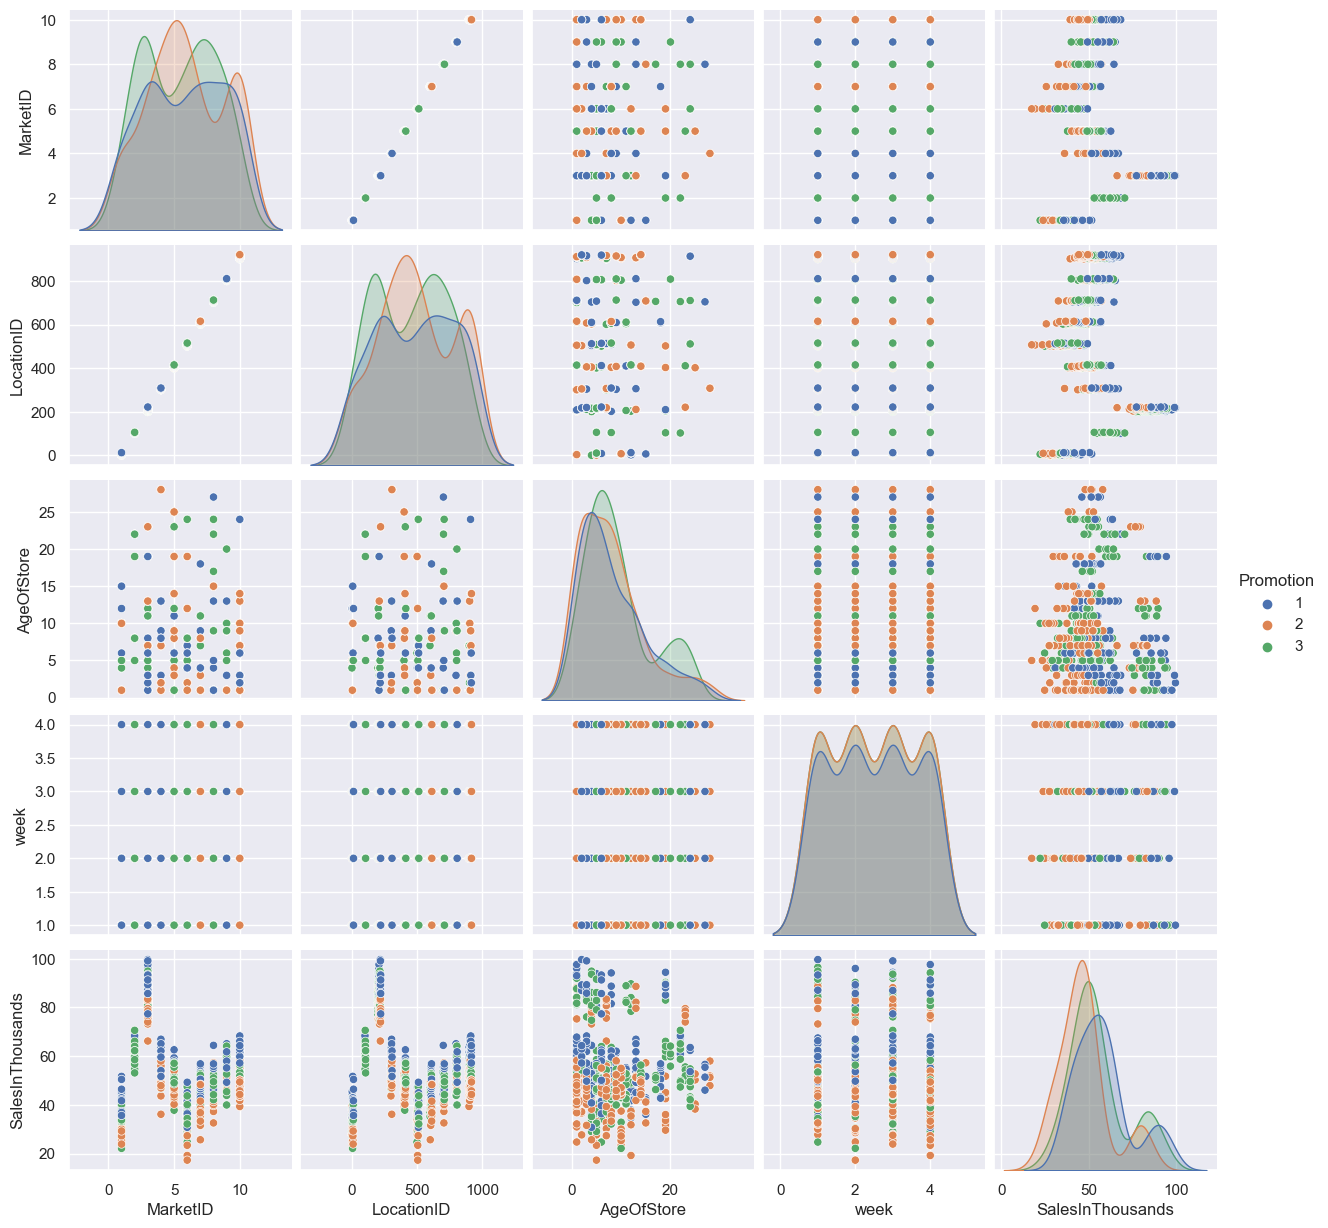

In [22]:
#Regardons le comportement des variables quantitatives entre elles grâce au pairplot de Seaborn
sns.pairplot(data = df, diag_kind = 'kde', hue = 'Promotion', palette = sns.color_palette());

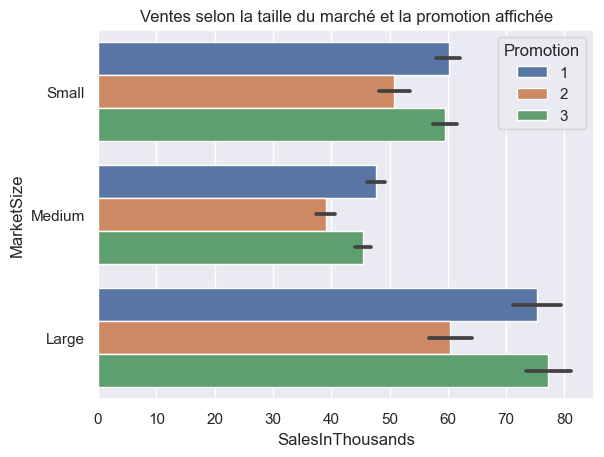

In [23]:
#En plus des graphiques du pairplot il est intéressant de creuser les ventes selon la taille du marché.
sns.barplot(x = 'SalesInThousands', y = 'MarketSize', hue = 'Promotion', data = df,
            order = ['Small', 'Medium', 'Large'])
plt.title('Ventes selon la taille du marché et la promotion affichée')
plt.savefig('ventes_marketsizeXpromotion')
plt.show()



Voici les conclusions que nous pouvons tirer de l'analyse bi-variée :
- La promotion 3 est plus présente dans les marchés mediums, et surtout dans des magasins implantés depuis plus longtemps en moyenne que les deux autres créations.
- Cependant, l'âge du magasin semble, de manière surprenante, avoir peu d'impact sur les ventes. Nous pouvons faire une distinction avant et après 16 ans. Avant 16 ans, la plupart des magasins sont répartis entre 10k et 60k, et un autre petit groupe entre 80k et 100k. Ceux de 16 ans ou plus tendent à se concentrer entre 40k et 70k. La chaîne a peut-être commencé à s'implanter dans des zones moins prisées, avant d'aller dans des zones avec des affluences plus fortes.
- Nous observons une répartition inégale de la diffusion des créations selon les marchés (MarketID) de la chaîne de fast-food. Or, certains marchés génèrent plus de ventes que d'autres. C'est surtout le cas du marché 3, où la promotion 3 n'est pas présente. Mais cette dernière est seule présente dans le marché 2.
- Dans l'ensemble, la promotion 2 semble être en retrait, alors que les promotions 1 et 3 semblent vraiment proches en termes d'impact sur les ventes.

### c. Analyse tri-variée

Nous pouvons regarder s'il y a eu des différences selon les semaines de diffusion croisées avec la taille du marché. 

C:\Users\cleme\AppData\Local\Temp\ipykernel_18200\2047138467.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.relplot(x = "week", y = "SalesInThousands", col = "MarketSize", hue = 'Promotion', data = df,
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


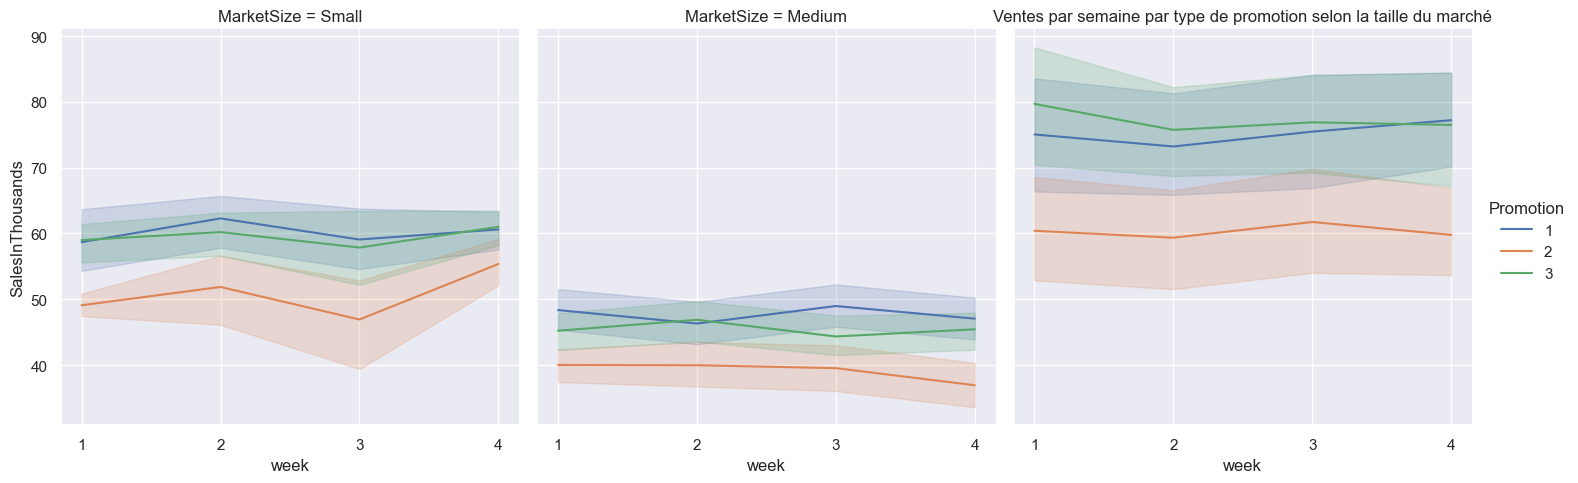

In [27]:
sns.relplot(x = "week", y = "SalesInThousands", col = "MarketSize", hue = 'Promotion', data = df,
             markers = True, kind = 'line', palette = sns.color_palette(), col_order = ['Small', 'Medium', 'Large'])
plt.xticks([1, 2, 3, 4])
plt.title('Ventes par semaine par type de promotion selon la taille du marché');

plt.savefig('ventes_weekXmarketsizeXpromotion')

Maintenant, voyons l'impact selon la taille du marché croisé avec l'âge du magasin.

C:\Users\cleme\AppData\Local\Temp\ipykernel_18200\726015154.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.relplot(x = "AgeOfStore", y = "SalesInThousands", col = "MarketSize", hue = 'Promotion',
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


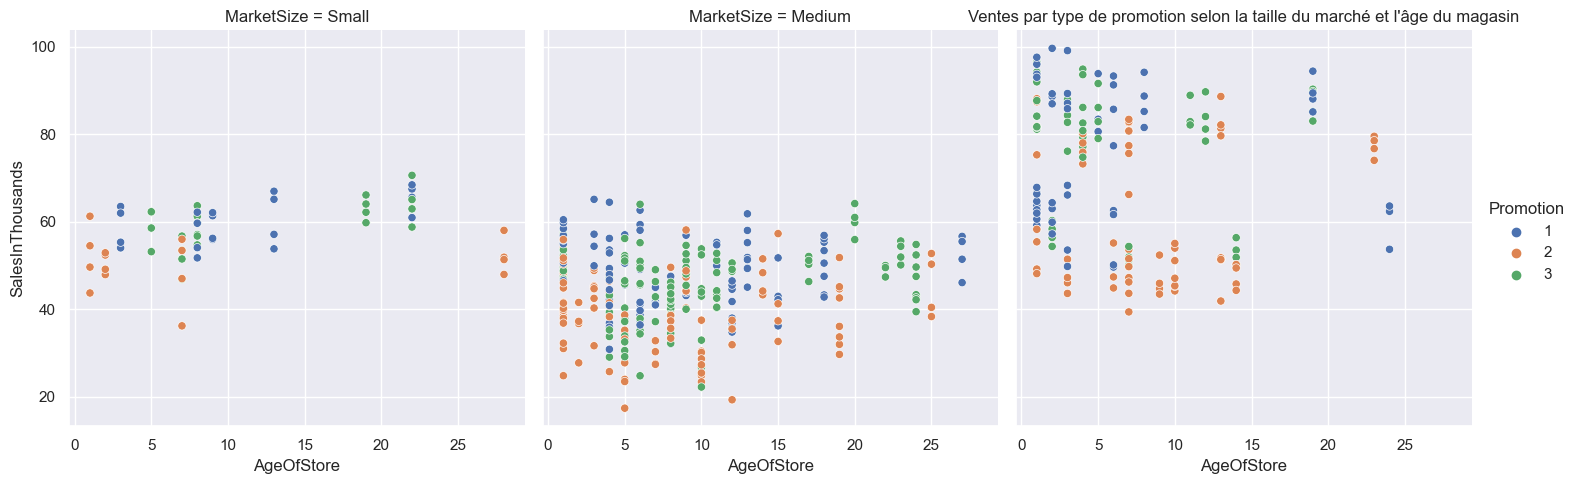

In [29]:
sns.relplot(x = "AgeOfStore", y = "SalesInThousands", col = "MarketSize", hue = 'Promotion', 
            data = df, palette = sns.color_palette(), col_order = ['Small', 'Medium', 'Large'], kind = 'scatter')
plt.title("Ventes par type de promotion selon la taille du marché et l'âge du magasin");

En analysant les variables selon la promotion et la taille de marché, nous obtenons des enseignements très intéressants :
- La promotion 2 est clairement en retrait par rapport aux deux autres.
- Nous n'observons pas de comportement particulier selon la temporalité de la campagne.
- Sur les petits marchés, il est difficile de tirer des conclusions, car les données sont bien peu nombreuses (environ 20 par type de promotion).
- Parmi les magasins récemment implantés (1 ans, et entre 2 et 5 ans), nous voyons que les ventes sont meilleures avec les promotions 2 et 3.

Pour y voir plus clair et valider ce constat, créons une variable catégorielle selon l'âge des magasins, avec les bornes suivantes :
- 0 à 5 ans : récemment implantés
- 5 à 10 ans : implantés
- Plus de 10 ans : implantés depuis longtemps

In [31]:
#Création de la variable catégorielle
df['AgeOfStore_cat'] = pd.cut(df['AgeOfStore'], [0, 5, 10, 30],
                             labels = ['0 à 5 ans', '5 à 10 ans', 'Plus de 10 ans'])

#Pour vérifier que les catégories sont suffisamment remplies pour réaliser des analyses.
display(df['AgeOfStore_cat'].value_counts())

print("\nVérifions que les effectifs croisés avec la taille du marché sont bien suffisants pour pouvoir regarder les statistiques.")

AgeOfStore_cat
0 à 5 ans         220
5 à 10 ans        168
Plus de 10 ans    160
Name: count, dtype: int64


Vérifions que les effectifs croisés avec la taille du marché sont bien suffisants pour pouvoir regarder les statistiques.


In [32]:
#Effectics croisés entre l'âge du magasin en catégorie et la taille du marché.
display(pd.crosstab(df['AgeOfStore_cat'], df['MarketSize']))

print('Nous pouvons faire une lecture sur les marchés mediums, mais pas sur les petits marchés.')
print("Pour les marchés larges, attention à la lecture au-delà de 5 ans, qui présente bien peu d'effectifs, mais peut donner une tendance.")

MarketSize,Large,Medium,Small
AgeOfStore_cat,,,
0 à 5 ans,80,124,16
5 à 10 ans,48,96,24
Plus de 10 ans,40,100,20


Nous pouvons faire une lecture sur les marchés mediums, mais pas sur les petits marchés.
Pour les marchés larges, attention à la lecture au-delà de 5 ans, qui présente bien peu d'effectifs, mais peut donner une tendance.


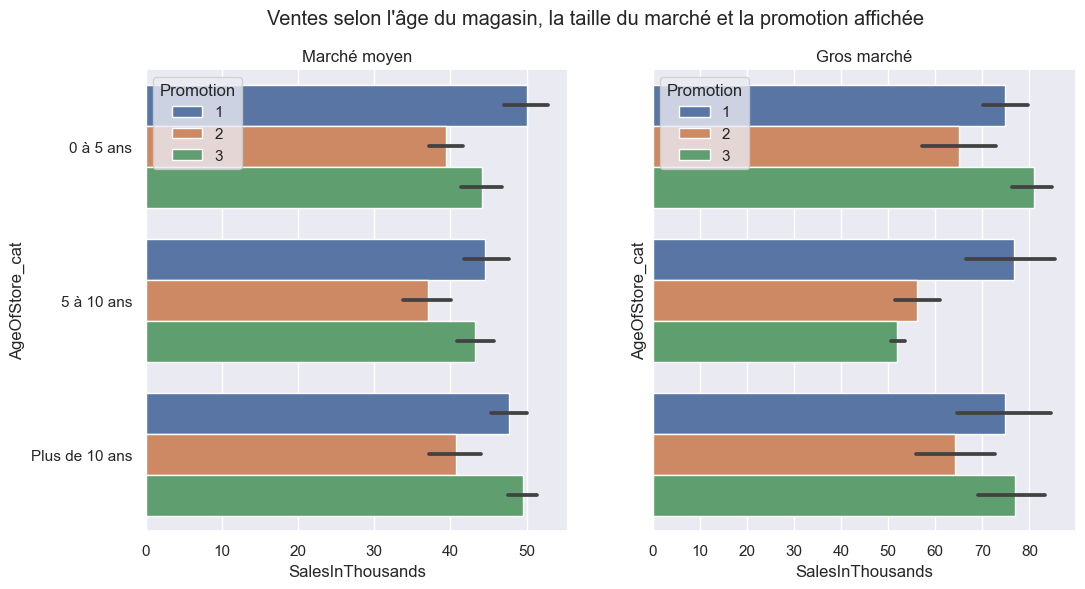

In [33]:

# Créer le graphique avec l'âge des magasins en catégories selon deux subplots en partageant l'axe des ordonnées
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 6], sharey=True)

# Premier subplot
sns.barplot(x='SalesInThousands', y='AgeOfStore_cat', hue='Promotion', data=df[df['MarketSize'] == 'Medium'], ax=ax1)
ax1.set_title("Marché moyen")

# Deuxième subplot
sns.barplot(x='SalesInThousands', y='AgeOfStore_cat', hue='Promotion', data=df[df['MarketSize'] == 'Large'], ax=ax2)
ax2.set_title("Gros marché")

# Ajouter un titre général à la figure
plt.suptitle("Ventes selon l'âge du magasin, la taille du marché et la promotion affichée")

# Afficher la figure
plt.show()

Ce graphique confirme l'intuition visuelle en ajoutant quelques nuances :
- Sur les marchés moyens, les promotions 1 et 3 sont proches, mais la promotion 1 a un léger avantage sur les magasins récemment implantés.
- Sur les gros marchés, idem, les deux promotions sont proches. A noter toutefois un retrait de la promotion 3 sur les magasins qui ont entre 5 et 10 ans.

Attention, certaines de ces nuances entre les promotions 1 et 3 peuvent être liées à des biais statistiques. Les supériorités peuvent être conditionnées au choix des magasins/marchés. Mais surtout, le retrait de la promotion 3 sur les 5 à 10 ans dans les marchés larges provient probablement d'une anomalie statistique due au manque de données (4 magasins) :

In [35]:
display(pd.crosstab(df['AgeOfStore_cat'], [df['MarketSize'], df['Promotion']]))

MarketSize     Large         Medium         Small       
Promotion          1   2   3      1   2   3     1  2   3
AgeOfStore_cat                                          
0 à 5 ans         36  16  28     32  56  36     4  8   4
5 à 10 ans        12  32   4     24  28  44     8  4  12
Plus de 10 ans     8  16  16     40  24  36     8  4   8

## 3. Test statistique

Maintenant que nous avons exploré le jeu de données, nous pouvons émettre les hypothèses suivantes :
- Les promotions ont des impacts différents les unes des autres.
- Les promotions 1 et 3 ont un impact plus important que la promotion 2.

En la présence d'une variable catégorielle (les promotions) et d'une variable continue (les ventes), c'est normalement un test ANOVA (ANalysis Of VAriance) qui est utilisé. Il vérifie s'il existe une différence significative entre les moyenne des groupes en comparant les variances de chaque groupe sur la variable cible.

Pour pouvoir réaliser ce test, plusieurs conditions doivent être respectées :
- La distribution doit suivre une loi normale
- La variance entre les groupes doit être proche

Nous avons vu graphiquement que la variable SalesInThousands ne suivait pas une distribution normale, et encore moins quand la variable promotion était associée. Nous pouvons vérifier stastiquement avec le test de Shapiro-Wilk :

In [38]:
#Import des librairies pour réaliser les tests
from scipy.stats import shapiro, levene, mannwhitneyu, kruskal
from statsmodels.stats.multicomp import MultiComparison

# Test de Shapiro Wilk pour vérifier si la distribution suit un loi normale

# H0: La distribution suit une loi normale.
# H1: La distribution ne suit pas une loi normale.

for group in list(df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == group, "SalesInThousands"])[1]
    print(group, 'p-value: %.4f' % pvalue)
    
# P-value < 0.05 donc H0 est rejeté. La variable ne suit pas une loi normale.

3 p-value: 0.0000
2 p-value: 0.0000
1 p-value: 0.0000


La première condition n'est donc pas remplie pour pouvoir réaliser un test ANOVA 'classique'. Dans le cas où elle était remplie, nous aurions dû tester la deuxième condition, à savoir la proximité entre les variances des trois groupes 'promotion' grâce au test Levene.

Nous allons donc utiliser un test ANOVA non-paramétrique (cf qui n'a pas besoin de répondre aux conditions présentées ci-dessus) : le test de Kruskal-Wallis.

In [40]:
# H0: Il n'y a pas de différences dans les ventes selon les promotions
# H1: Il y a une différence dans les ventes selon les promotions

test_stat, pvalue = kruskal(df.loc[df['Promotion'] == 1, "SalesInThousands"],
                            df.loc[df['Promotion'] == 2, "SalesInThousands"],
                            df.loc[df['Promotion'] == 3, "SalesInThousands"])

print("pvalue: ", "%.3f" % pvalue)

# P-value < 0.05 donc H0 est rejeté. Il y a bel et bien une différence dans les ventes selon les promotions.

pvalue:  0.000


Maintenant que la différence est établie, regardons quelles sont les dynamiques entre les promotions grâce au test des étendues de Tukey, avec une marge d'erreur de 5% :

In [42]:
# Les hypothèses sont les mêmes que pour le test de Kruksal-Wallis, mais entre chaque promotion.

comparison = MultiComparison(df["SalesInThousands"], df["Promotion"])
tukey = comparison.tukeyhsd(0.05)
print(tukey.summary())



 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


L'hypothèse 0 est rejetée entre les promotions 1 et 2, et entre les promotions 2 et 3. En revanche, pas de différence constatée entre les promotions 1 et 3. 

Nous pouvons donc conclure que les promotions 1 et 3 génèrent plus de ventes que la promotion 2.

Pour aller plus loin, pour départager les promotions 1 et 3, nous pouvons nous demander si nous constatons des différences significatives sur la taille du marché et sur l'âge des magasins.

In [44]:
comparison = MultiComparison(df["SalesInThousands"], df["MarketSize"].astype('str') + df["Promotion"].astype('str') )
tukey = comparison.tukeyhsd(0.05)
print(tukey.summary())


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1  group2 meandiff p-adj   lower    upper   reject
--------------------------------------------------------
 Large1  Large2 -14.9139    0.0 -21.0355  -8.7922   True
 Large1  Large3   1.9681 0.9911  -4.6125   8.5486  False
 Large1 Medium1 -27.5633    0.0 -33.1887 -21.9379   True
 Large1 Medium2 -36.1215    0.0 -41.6306 -30.6125   True
 Large1 Medium3  -29.767    0.0 -35.2108 -24.3232   True
 Large1  Small1 -15.0734    0.0 -23.7882  -6.3586   True
 Large1  Small2 -24.4253    0.0 -33.9089 -14.9417   True
 Large1  Small3 -15.7217    0.0 -23.8839  -7.5595   True
 Large2  Large3  16.8819    0.0   10.494  23.2698   True
 Large2 Medium1 -12.6494    0.0 -18.0482  -7.2506   True
 Large2 Medium2 -21.2077    0.0 -26.4851 -15.9302   True
 Large2 Medium3 -14.8532    0.0 -20.0624  -9.6439   True
 Large2  Small1  -0.1595    1.0  -8.7298   8.4108  False
 Large2  Small2  -9.5114 0.0427 -18.8624  -0.1604   True
 Large2  Small3  -0.8079    1.0

Sur la taille de marché, il n'y a pas de significativité entre les promotions 1 et 3 par taille du marché (small1 vs small3 par exemple).

In [46]:
comparison = MultiComparison(df["SalesInThousands"], df["AgeOfStore_cat"].astype('str') + df["Promotion"].astype('str') )
tukey = comparison.tukeyhsd(0.05)
print(tukey.summary())


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------
     0 à 5 ans1      0 à 5 ans2 -17.1148    0.0 -25.0226 -9.2069   True
     0 à 5 ans1      0 à 5 ans3  -2.6868 0.9843 -10.9185   5.545  False
     0 à 5 ans1     5 à 10 ans1  -7.1551 0.2902 -16.4702  2.1599  False
     0 à 5 ans1     5 à 10 ans2 -15.6411    0.0  -24.004 -7.2781   True
     0 à 5 ans1     5 à 10 ans3 -16.3411    0.0 -24.8504 -7.8319   True
     0 à 5 ans1 Plus de 10 ans1   -9.086 0.0319 -17.7595 -0.4126   True
     0 à 5 ans1 Plus de 10 ans2 -12.6076  0.001 -21.9227 -3.2926   True
     0 à 5 ans1 Plus de 10 ans3  -4.1865   0.84 -12.6957  4.3228  False
     0 à 5 ans2      0 à 5 ans3   14.428    0.0   6.3987 22.4573   True
     0 à 5 ans2     5 à 10 ans1   9.9596 0.0209    0.823 19.0963   True
     0 à 5 ans2     5 à 10 ans2   1.4737 0.9998  -6.6901  9.6375

Idem, sur l'âge du magasin, nous ne constatons pas de différences entre la promotion 1 et 3.

## 4. Quantification de l'impact

Maintenant, quantifions le gain permis par les promotions 1 et 3 par rapport à la promotion 2.

In [50]:
pivot_table = pd.pivot_table(df, values='SalesInThousands', index='Promotion', aggfunc=[np.count_nonzero, np.mean, np.median, np.std])
pivot_table

,count_nonzero,mean,median,std
,SalesInThousands,SalesInThousands,SalesInThousands,SalesInThousands
Promotion,,,,
1,172,58.099012,55.385,16.553782
2,188,47.329415,45.385,15.108955
3,188,55.364468,51.165,16.766231


In [51]:
evol_1vs2 = round((pivot_table['mean'].iloc[0][0] - pivot_table['mean'].iloc[1][0]) / pivot_table['mean'].iloc[1][0] * 100, 2)
evol_3vs2 = round((pivot_table['mean'].iloc[2][0] - pivot_table['mean'].iloc[1][0]) / pivot_table['mean'].iloc[1][0] * 100, 2)

print('Différence en % entre la promotion 1 et la promotion 2 :', evol_1vs2)
print('Différence en % entre la promotion 3 et la promotion 2 :', evol_3vs2)


Différence en % entre la promotion 1 et la promotion 2 : 22.75
Différence en % entre la promotion 3 et la promotion 2 : 16.98


Bien qu'aucune significativé entre les promotions 1 et 3 sur la taille des marchés et l'âge des magasins, il est intéressant d'avoir un tableau comparatif. 

In [53]:
pivot_table_marketsize = pd.pivot_table(df, values='SalesInThousands', index=['MarketSize', 'Promotion'], aggfunc=[np.count_nonzero, np.mean, np.median, np.std])
pivot_table_marketsize

count_nonzero             mean           median  \
                     SalesInThousands SalesInThousands SalesInThousands   
MarketSize Promotion                                                      
Large      1                       56        75.235893           72.835   
           2                       64        60.322031           53.010   
           3                       48        77.203958           82.345   
Medium     1                       96        47.672604           47.425   
           2                      108        39.114352           39.765   
           3                      116        45.468879           46.295   
Small      1                       20        60.162500           61.145   
           2                       16        50.810625           51.600   
           3                       24        59.514167           59.745   

                                  std  
                     SalesInThousands  
MarketSize Promotion                   
Large      1                15.497497  
           2                15.728529  
           3                14.400304  
Medium     1                 8.067331  
           2                 8.807407  
           3                 8.091366  
Small      1                 5.127279  
           2                 5.869816  
           3                 5.212687

In [54]:
pivot_table_ageofstore = pd.pivot_table(df, values='SalesInThousands', index=['AgeOfStore_cat', 'Promotion'], aggfunc=[np.count_nonzero, np.mean, np.median, np.std])
pivot_table_ageofstore

count_nonzero             mean           median  \
                         SalesInThousands SalesInThousands SalesInThousands   
AgeOfStore_cat Promotion                                                      
0 à 5 ans      1                       72        62.887639           59.820   
               2                       80        45.772875           44.960   
               3                       68        60.200882           54.935   
5 à 10 ans     1                       44        55.732500           50.915   
               2                       64        47.246563           45.385   
               3                       60        46.546500           46.215   
Plus de 10 ans 1                       56        53.801607           52.600   
               2                       44        50.280000           48.130   
               3                       60        58.701167           52.575   

                                      std  
                         SalesInThousands  
AgeOfStore_cat Promotion                   
0 à 5 ans      1                17.278220  
               2                14.544923  
               3                20.258729  
5 à 10 ans     1                17.279040  
               2                14.889495  
               3                 9.312721  
Plus de 10 ans 1                13.411444  
               2                16.304791  
               3                14.859892

# Conclusion

Après avoir vérifié la qualité des données, nous avons visualisé les données pour nous assurer qu'il n'y avait pas de problème de qualité, pour analyser les distributions et pour révéler les relations entre les variables, notamment en lien avec les promotions et les ventes par magasin.

Visuellement, il était clair que les promotions 1 et 3 avaient bien mieux fonctionné que la promotion 2. Aussi, l'un des graphiques a mis en évidence quelques différences entre les promotions 1 et 3 selon la taille du marché croisé à l'âge des magasins.

Le test statistique adéquat a permis d'établir que les promotions 1 et 3 fonctionnaient mieux que la promotion 2. En revanche, les différences selon la taille des marchés ou l'âge des magasins n'ont pas été validées.

### Implications pour le business

La chaîne de fast-food devrait choisir la promotion 1 et/ou la promotion 3, qui donnent des résultats comparables.

Si la marque devait faire un choix, voici quelques critères non exhaustifs pour aider à choisir :
- L'impact sur les coûts : la promotion la plus intressante en termes de coûts
- Une logistique/préparation plus facile
- La satisfaction des consommateurs : le marché de la restauration rapide étant très compétitif, la rétention constitue un enjeu primordial
- L'attente/le désir qu'elle peut susciter
- La cohérence avec le positionnement marketing...
- ...ou au contraire un moyen de faire évoluer le positionnement si tel est le souhait
- Et, à ne pas sous-estimer... l'affinité et l'intuition, ce petit truc en plus qu'on choisit ou non d'écouter ! Même dans le milieu professionnel, le plaisir est essentiel, tout comme l'alignement avec ses valeurs personnelles :).

### Limites

La principale limite du projet concerne le manque de données en ligne et en colonne.

En ligne, plus de données aurait peut-être permis d'établir des significativités sur des segments comme la taille du marché ou l'âge des magasins.

En colonne, de nouvelles variables aurait peut-être permis de découvrir d'autres différences. Par exemple : la réussite des promotions selon le niveau de concurrence, la région, le type de territoires...

### Pour aller plus loin

Il existe des modèles de Machine Learning dits 'causaux', qui permettent de prendre en compte dans le calcul les biais liées à la selection des magasins du test. Il aurait été intéressant de tester cette approche pour analyser la différence de résultats.

###  Apport personnel du projet

Ce projet a été un l'objet d'un apprentissage important de ma part... car plus difficile qu'attendu.

D'abord, j'ai fait un travail de recherche général sur l'A/B testing avant de me lancer, au sujet de la mise en place, comment choisir l'échantillon, quelles sont les étapes de ce type de projet etc.

Mais c'est l'apprentissage statistique qui a été le plus important. En effet, j'ai vraiment pris conscience de l'importance de choisir les bons tests statistiques selon le type de données que nous avons à disposition, et de leur distribution. 

Le test ANOVA nécessite une distribution normale des données et des variances proches entre les catégories pour comparer les moyennes. Or, ici, ce n'était pas le cas. Tout d'abord, j'ai appris l'existence de tests pour vérifier ces conditions. Ensuite, j'ai poussé ma compréhension en prenant connaissance des principaux tests, et dans quelles condition les utiliser.

Des enseignements précieux pour de futurs A/B testings :).